In [248]:
import csv
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SpotifyChallenge").getOrCreate()

df = spark.read.csv("../stream-processing-template/assets/data/spotify-2023.csv", header=True, inferSchema=True)

### Tasks:

#### Most Streamed & Highest Ranking Tracks:

Identify the top 5 tracks with the highest number of streams in 2023. <br>
Identify the top 5 ranking tracks across all platforms. <br>
Is there any crossover between these two findings?


### Top 5 tracks in number of streams

First, we import teh integertype cast module


In [ ]:
from pyspark.sql.types import IntegerType

from there we convert the whole 'streams' column to integers

In [249]:
df = df.withColumn('streams', df['streams'].cast(IntegerType()))

In [ ]:
# df = df.filter(df.streams.isnotNull())

then, we create our top5 df, ordering by the desc number of streams

In [250]:
top5_streams = df[['track_name', 'artist(s)_name', 'streams']].orderBy(df.streams.desc()).limit(5)

In [251]:
top5_streams.show()

+-----------------+--------------+----------+
|       track_name|artist(s)_name|   streams|
+-----------------+--------------+----------+
|Take Me To Church|        Hozier|2135158446|
|          Circles|   Post Malone|2132335812|
|    Love Yourself| Justin Bieber|2123309722|
|        All of Me|   John Legend|2086124197|
|   Counting Stars|   OneRepublic|2011464183|
+-----------------+--------------+----------+



### Top 5 across all platforms


This is basically the same as the previous exercise. Since there is not a column with this info, we can create one that will be result of the sum of each individual chart presence.


In [252]:
chart_presence = df.withColumn("total_charts_presence", df.in_spotify_charts + df.in_apple_charts + df.in_deezer_charts + df.in_shazam_charts)

Now we have our original df with an extra column. We can now order by total presence and select only the top 5.

In [253]:
chart_presence = chart_presence.select('track_name', 'total_charts_presence').orderBy(chart_presence.total_charts_presence.desc()).limit(5)

In [254]:
chart_presence.show()

+--------------------+---------------------+
|          track_name|total_charts_presence|
+--------------------+---------------------+
|             vampire|               1283.0|
|            Sprinter|               1267.0|
|            fukumean|               1257.0|
|Seven (feat. Latt...|               1246.0|
|              Tattoo|               1104.0|
+--------------------+---------------------+



Lets compare the 2 df side by side.

In [255]:
top5_streams.show()

+-----------------+--------------+----------+
|       track_name|artist(s)_name|   streams|
+-----------------+--------------+----------+
|Take Me To Church|        Hozier|2135158446|
|          Circles|   Post Malone|2132335812|
|    Love Yourself| Justin Bieber|2123309722|
|        All of Me|   John Legend|2086124197|
|   Counting Stars|   OneRepublic|2011464183|
+-----------------+--------------+----------+



In [256]:
chart_presence.show()

+--------------------+---------------------+
|          track_name|total_charts_presence|
+--------------------+---------------------+
|             vampire|               1283.0|
|            Sprinter|               1267.0|
|            fukumean|               1257.0|
|Seven (feat. Latt...|               1246.0|
|              Tattoo|               1104.0|
+--------------------+---------------------+



### Artists with most tracks in Spotify Charts

I will start this one by selecting only the artist with in_spotify_charts different than 0. Meaning, only those who are ranked in Spotify.

In [257]:
from pyspark.sql.functions import *


For this one, the first idea was to simply group by artist and COUNT. However, some artists have their name on a feat and might not be considered. So before I start, I will separate the cells with multiple artists into multiple single-artist cells.

In [258]:
top_spotify_artists = df.select(explode(split('artist(s)_name', ',')), 'in_spotify_charts').filter(df.in_spotify_charts != 0)

In [259]:
top_spotify_artists = top_spotify_artists.groupBy(top_spotify_artists['col']).count()

In [260]:
top_spotify_artists = top_spotify_artists.orderBy(top_spotify_artists['count'].desc())

In [261]:
top_spotify_artists.show(10)

+-------------+-----+
|          col|count|
+-------------+-----+
| Taylor Swift|   22|
|    Bad Bunny|   19|
|   The Weeknd|   16|
|         Feid|   11|
|    Bad Bunny|   11|
|   Peso Pluma|   11|
| Harry Styles|   10|
|      Karol G|    9|
| Metro Boomin|    8|
|        Drake|    7|
+-------------+-----+
only showing top 10 rows



### Attributes of Danceable Tracks

Extract tracks with a danceability percentage of more than 80% and display their name, artist, bpm (beats per minute), and danceability percentage. <br>
Identify any possible correlation between danceability and bpm.

In [269]:
danceable_df = df.filter(df['danceability_%'] > 80).select('track_name', 'artist(s)_name', 'bpm', 'danceability_%')
danceable_df = danceable_df.withColumn('bpm', danceable_df.bpm.cast('integer'))


In [271]:
danceable_df.show(10)

+--------------------+--------------------+---+--------------+
|          track_name|      artist(s)_name|bpm|danceability_%|
+--------------------+--------------------+---+--------------+
|            Sprinter|   Dave, Central Cee|141|            92|
|            fukumean|               Gunna|130|            85|
|     La Bebe - Remix|Peso Pluma, Yng L...|170|            81|
|          Classy 101|    Feid, Young Miko|100|            86|
|Peso Pluma: Bzrp ...|Bizarrap, Peso Pluma|133|            85|
|Popular (with Pla...|The Weeknd, Madon...| 99|            85|
|        MOJABI GHOST|    Tainy, Bad Bunny|122|            81|
|     Los del Espacio|Big One, Duki, Li...|120|            81|
|            AMARGURA|             Karol G|107|            92|
|          La Bachata|       Manuel Turizo|125|            84|
+--------------------+--------------------+---+--------------+
only showing top 10 rows



We can first use corr() and see if there is any correlation.

In [263]:
danceable_df.corr('bpm', 'danceability_%')

0.016846197056879814

The number is really close to 0, meaning that there is no correlation between BPM and danceability.

However, we can still plot some graphs.

In [264]:
import matplotlib.pyplot as plt
import numpy as np

Lets plot danceability x bpm and see how it looks.

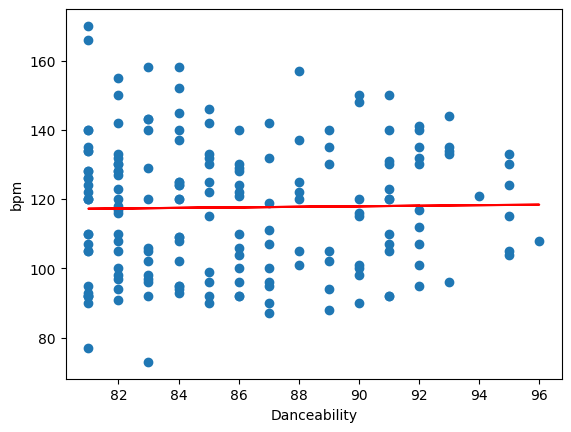

In [265]:
x = np.array(danceable_df.rdd.map(lambda x : x[3]).collect())
y = np.array(danceable_df.rdd.map(lambda x : x[2]).collect())

plt.xlabel('Danceability')
plt.ylabel('bpm')


a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a * x + b, color='red')

plt.show()

Now, lets see how each bpm plots againsts its avg danceability.

In [266]:
avg_danceability_per_bpm = danceable_df.groupBy(danceable_df['bpm']).avg('danceability_%')

In [267]:
avg_danceability_per_bpm.orderBy(avg_danceability_per_bpm['avg(danceability_%)'].desc()).show()

+---+-------------------+
|bpm|avg(danceability_%)|
+---+-------------------+
|144|               93.0|
|141|               92.0|
|112|               92.0|
|131|               91.0|
|104|               90.5|
|148|               90.0|
|101|               90.0|
|115|               90.0|
|121|               90.0|
| 88|               89.0|
|133|              88.75|
|135|              88.75|
|157|               88.0|
|107|              87.75|
|130|              87.75|
|150|  87.66666666666667|
|108|  87.33333333333333|
|111|               87.0|
|117|               87.0|
| 87|               87.0|
+---+-------------------+
only showing top 20 rows



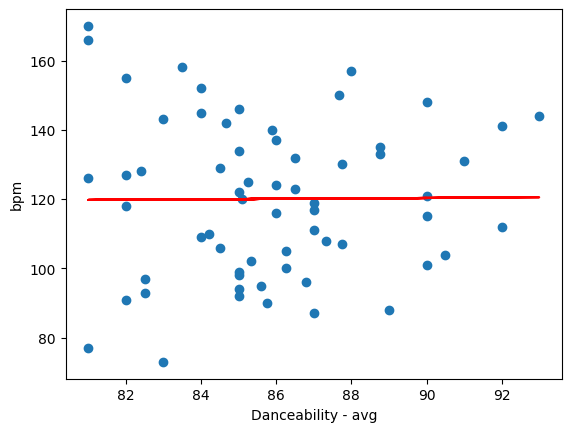

In [268]:
y = np.array(avg_danceability_per_bpm.rdd.map(lambda x : x[0]).collect())
x = np.array(avg_danceability_per_bpm.rdd.map(lambda x : x[1]).collect())

plt.xlabel('Danceability - avg')
plt.ylabel('bpm')

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, color='red')

plt.scatter(x, y)

plt.show()